In [6]:
%matplotlib inline
import os
import sys

#uncomment if cloned from github!
sys.path.append("../")

from sapsan.lib.backends.fake import FakeExperimentBackend
from sapsan.lib.backends.mlflow import MlFlowExperimentBackend
from sapsan.lib.data.jhtdb_dataset import JHTDB128Dataset
from sapsan.lib.data import Equidistance3dSampling
from sapsan.lib.estimator import Spacial3dEncoderNetworkEstimator, Spacial3dEncoderNetworkEstimatorConfiguration
from sapsan.lib.experiments.evaluation_3d import Evaluation3dExperiment
from sapsan.lib.experiments.training import TrainingExperiment

In [7]:
#--- Experiment tracking backend ---

os.environ["AWS_ACCESS_KEY_ID"] = "<AWS_ACCESS_KEY_ID>"
os.environ["AWS_SECRET_ACCESS_KEY"] = "<AWS_SECRET_ACCESS_KEY>"

experiment_name = "CNN experiment"

#Fake (disable backend)
tracking_backend = FakeExperimentBackend(experiment_name)

#MLflow
#launch mlflow with: mlflow ui --port=9000
#uncomment tracking_backend to use mlflow

MLFLOW_BACKEND_HOST = "localhost"
MLFLOW_BACKEND_PORT = 9000

#tracking_backend = MlFlowExperimentBackend(experiment_name, MLFLOW_BACKEND_HOST, MLFLOW_BACKEND_PORT)

In [8]:
#--- Data setup ---
#In the intereset of loading and training multiple timesteps
#one can specify which checkpoints to use and where
#they appear in the path via syntax: {checkpoint:format}
#
#Next, you need to specify which features to load; let's assume 
#        path = "{feature}.h5"
#
# 1) If in different files, then specify features directly
#    Ex: features = ['velocity', 'denisty', 'pressure']
# 2) If in the same, then duplicate the name in features
#    and specify which labels to pull
#    Ex: features = ["data", "data", "data"]
#        feature_labels = ['velocity', 'density', 'pressure']

path = "data/t{checkpoint:1.0f}/{feature}_dim32_fm15.h5"
features = ['u']
target = ['u']

#Dimensionality of your data per axis
CHECKPOINT_DATA_SIZE = 32

#Reduce dimensionality of each axis to
SAMPLE_TO = 16

#Dimensionality of each axis in a batch
GRID_SIZE = 8

#Sampler to use for reduction
sampler = Equidistance3dSampling(CHECKPOINT_DATA_SIZE, SAMPLE_TO)

In [13]:
#--- Train the model ---
#Machine Learning model to use
estimator = Spacial3dEncoderNetworkEstimator(
    config=Spacial3dEncoderNetworkEstimatorConfiguration(n_epochs=1, grid_dim=GRID_SIZE)
)

#Load the data
x, y = JHTDB128Dataset(path=path,
                       features=features,
                       target=target,
                       checkpoints=[0],
                       grid_size=GRID_SIZE,
                       checkpoint_data_size=CHECKPOINT_DATA_SIZE,
                       sampler=sampler).load()

#Set the experiment
training_experiment = TrainingExperiment(name=experiment_name,
                                         backend=tracking_backend,
                                         model=estimator,
                                         inputs=x, targets=y)
#Train the model
training_experiment.run()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[2020-05-05 14:22:17,685] 
0/1 * Epoch 0 (train): _base/lr=0.0010 | _base/momentum=0.9000 | _timers/_fps=43.1104 | _timers/batch_time=0.0928 | _timers/data_time=0.0686 | _timers/model_time=0.0241 | loss=0.0115
0/1 * Epoch 0 (valid): _base/lr=0.0010 | _base/momentum=0.9000 | _timers/_fps=21.0067 | _timers/batch_time=0.1904 | _timers/data_time=0.1484 | _timers/model_time=0.0417 | loss=0.0103


INFO:metrics_logger:
0/1 * Epoch 0 (train): _base/lr=0.0010 | _base/momentum=0.9000 | _timers/_fps=43.1104 | _timers/batch_time=0.0928 | _timers/data_time=0.0686 | _timers/model_time=0.0241 | loss=0.0115
0/1 * Epoch 0 (valid): _base/lr=0.0010 | _base/momentum=0.9000 | _timers/_fps=21.0067 | _timers/batch_time=0.1904 | _timers/data_time=0.1484 | _timers/model_time=0.0417 | loss=0.0103


Top best models:
logs/checkpoints//train.0.pth	0.0103


{'runtime': 2.047971487045288}

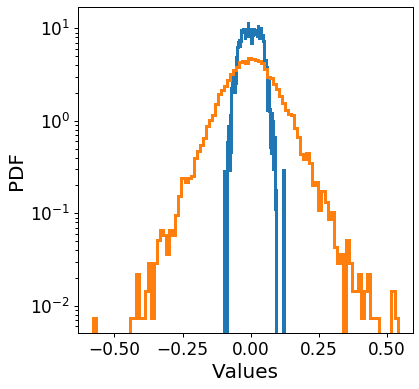

<Figure size 432x432 with 0 Axes>

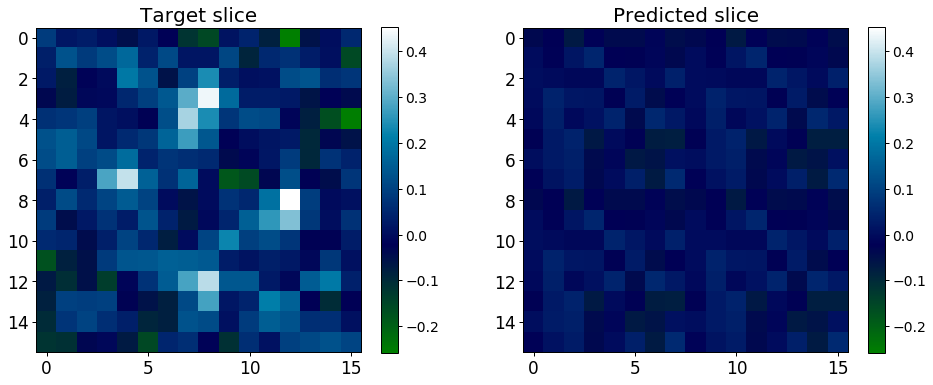

{'runtime': 1.7958292961120605}

In [14]:
#--- Test the model ---
#Load the test data
x, y = JHTDB128Dataset(path=path,
                       features=features,
                       target=target,
                       checkpoints=[0],
                       grid_size=GRID_SIZE,
                       checkpoint_data_size=CHECKPOINT_DATA_SIZE,
                       sampler=sampler).load()

#Set the test experiment
evaluation_experiment = Evaluation3dExperiment(name=experiment_name,
                                               backend=tracking_backend,
                                               model=training_experiment.model,
                                               inputs=x, targets=y,
                                               grid_size=GRID_SIZE,
                                               checkpoint_data_size=SAMPLE_TO)

#Test the model
evaluation_experiment.run()